In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings('ignore')
import random
import os
import tensorflow as tf
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.layers import LSTM , Embedding , Flatten , Dense
from keras.regularizers import L2
from sklearn.metrics import r2_score , mean_squared_error
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA

In [2]:
df = pd.read_csv(r'AdventureWorksForecasting.csv')
df.head()

,Unnamed: 0,OrderDate,CustomerKey,Age,Income,Gender,ProductKey,UnitPrice,GeographyKey,City,CountryRegionCode,DiscountPct,SalesAmount,OrderQuantity
0,0,2013-12-30,29282,1955-03-13,30000.0,F,478,9.99,41,Calgary,CA,0.0,9.99,1
1,1,2013-12-30,29282,1955-03-13,30000.0,F,478,9.99,42,Edmonton,CA,0.0,9.99,1
2,2,2013-12-30,29282,1955-03-13,30000.0,F,478,9.99,43,Burnaby,CA,0.0,9.99,1
3,3,2013-12-30,29282,1955-03-13,30000.0,F,478,9.99,44,Burnaby,CA,0.0,9.99,1
4,4,2013-12-30,29282,1955-03-13,30000.0,F,478,9.99,45,Burnaby,CA,0.0,9.99,1


In [3]:
df['OrderDate'] = pd.to_datetime(df['OrderDate'])

In [4]:
df.sort_values(by='OrderDate', ascending=True, inplace= True)
df = df[['OrderDate','SalesAmount']]
df.head()

,OrderDate,SalesAmount
157083,2010-12-29,3399.9900
156981,2010-12-29,699.0982
156980,2010-12-29,699.0982
156979,2010-12-29,699.0982
156978,2010-12-29,699.0982


In [5]:
time_series_data = df.groupby('OrderDate', as_index=False).sum()
time_series_data

,OrderDate,SalesAmount
0,2010-12-29,9.313975e+05
1,2010-12-30,8.685703e+05
2,2010-12-31,1.232194e+06
3,2011-01-01,5.295840e+05
4,2011-01-02,9.583141e+05
...,...,...
1119,2014-01-24,1.053759e+05
1120,2014-01-25,1.195189e+05
1121,2014-01-26,1.566994e+05
1122,2014-01-27,1.077891e+05


In [6]:
time_series_data.describe()

,SalesAmount
count,1.124000e+03
mean,1.807865e+06
std,1.279797e+06
min,6.343027e+04
25%,8.764838e+05
50%,1.437487e+06
75%,2.487121e+06
max,7.006593e+06


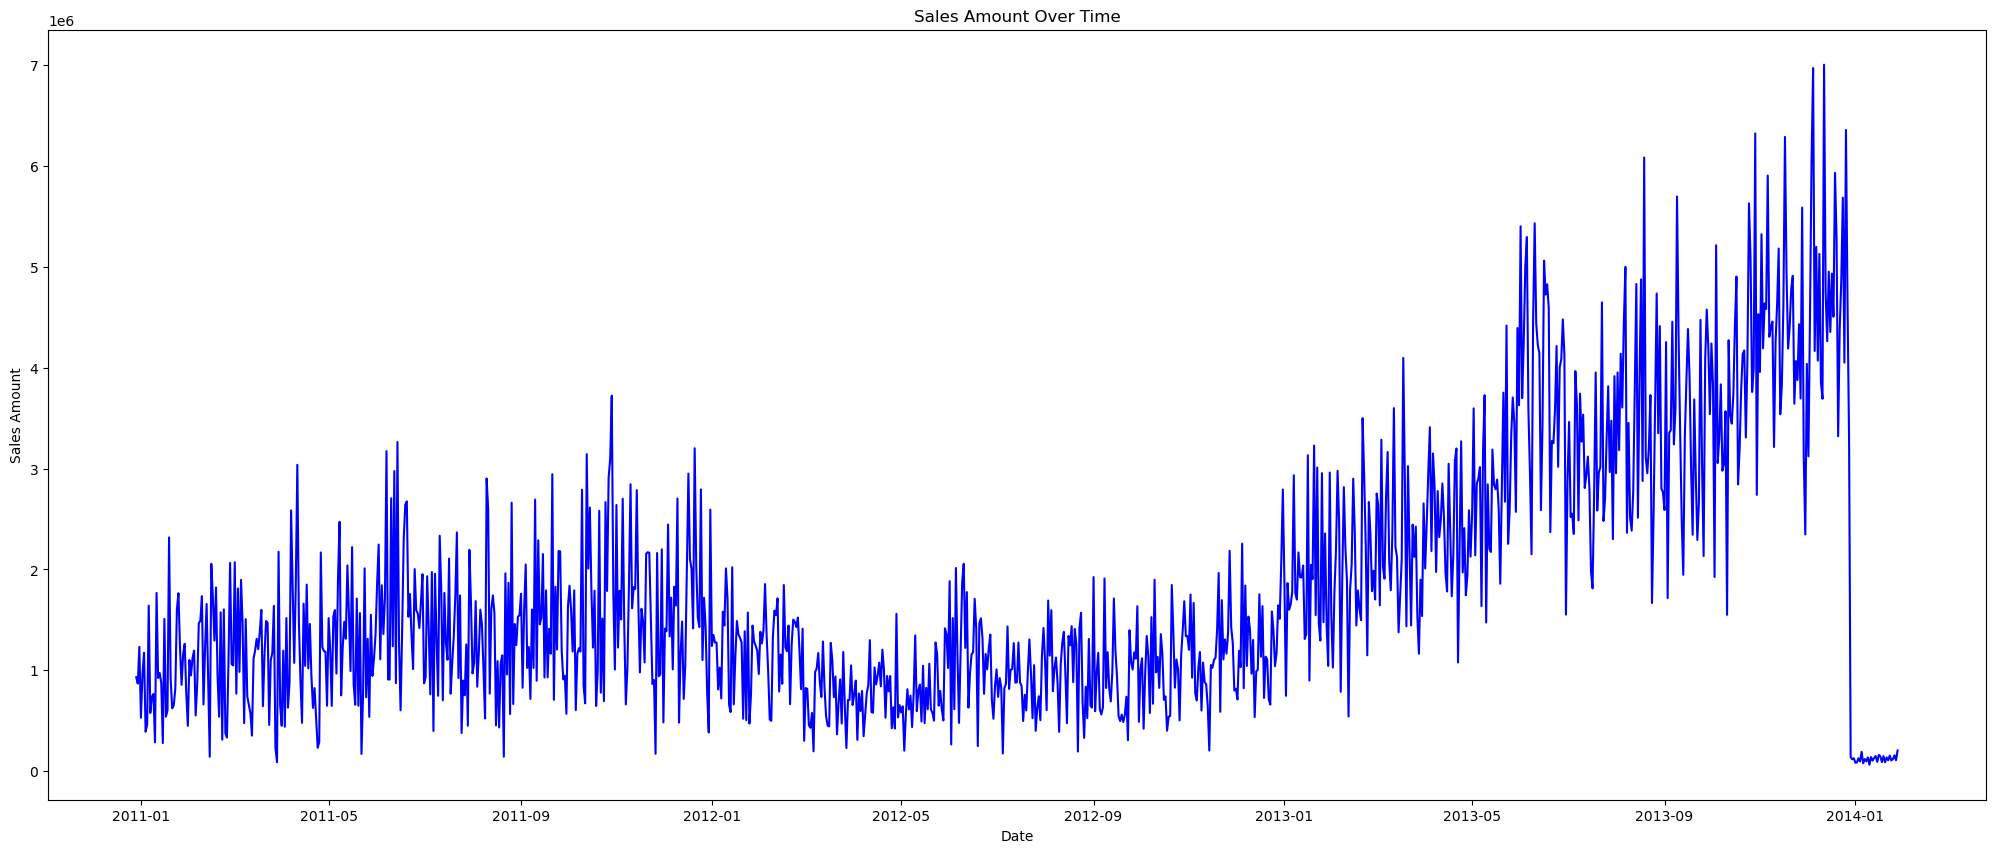

In [7]:
plt.figure(figsize=(25,10))
plt.plot(time_series_data['OrderDate'], time_series_data['SalesAmount'], color='blue')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.title('Sales Amount Over Time')
plt.show()

In [8]:
# preparing Input and Output
def create_sequences(data,n_steps):
  X,y=[],[]
  for i in range(0,len(data)-1-n_steps):
    seq_X = data[i : i+n_steps]
    seq_y = data[i+n_steps]
    X.append(seq_X)
    y.append(seq_y)

  return np.array(X),np.array(y)


data = time_series_data['SalesAmount'].values
n_steps = 365
X, y = create_sequences(data, n_steps)
print(f"Length of X : {len(X)}, Length of y : {len(y)}")

Length of X : 758, Length of y : 758


In [9]:
# Train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

# Reshape X_test to have 1 timestep and 5 features
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
# Check the shape of the reshaped input
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (606, 1, 365)
X_test shape: (152, 1, 365)


# Finding best possible combination

In [10]:
# import itertools

# # Define hyperparameters
# layer1_neurons = [365, 250, 128, 70]
# layer2_neurons = [128, 70, 35, 10]
# activation_funcs = ['relu']
# epochs = [50,75,100]
# batch_sizes = [1, 2]

# # Lists to store results
# results = []

# # Iterate over all combinations of hyperparameters
# for layer1_neuron, layer2_neuron, activation_func, epoch, batch_size in itertools.product(layer1_neurons, layer2_neurons, activation_funcs, epochs, batch_sizes):
#     print(f"Training model with parameters: layer1_neurons={layer1_neuron}, layer2_neurons={layer2_neuron}, activation_func={activation_func}, epochs={epoch}, batch_size={batch_size}")

#     model = Sequential()
#     model.add(LSTM(layer1_neuron, activation=activation_func, input_shape=(1, 365), return_sequences=True))
#     model.add(LSTM(layer2_neuron, activation=activation_func, input_shape=(1, 365), return_sequences=False))
#     model.add(Dense(1))

#     model.compile(loss='mae', optimizer='adam')

#     history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epoch, verbose=1)

#     y_pred = model.predict(X_test, verbose=0)

#     rmse = (mean_squared_error(y_test, y_pred))**0.5

#     results.append({
#         'layer1_neurons': layer1_neuron,
#         'layer2_neurons': layer2_neuron,
#         'activation_func': activation_func,
#         'epochs': epoch,
#         'batch_size': batch_size,
#         'rmse': rmse
#     })

In [11]:
# # Convert results to DataFrame
# df_results = pd.DataFrame(results)

# # Sort DataFrame by RMSE in descending order
# df_results_sorted = df_results.sort_values(by='rmse', ascending=True)

# df_results_sorted

# Building Best model

Epoch 1/100
303/303 [==============================] - 7s 9ms/step - loss: 1338972.3750
Epoch 2/100
303/303 [==============================] - 3s 10ms/step - loss: 1292102.3750
Epoch 3/100
303/303 [==============================] - 3s 12ms/step - loss: 1328726.1250
Epoch 4/100
303/303 [==============================] - 4s 12ms/step - loss: 1427590.7500
Epoch 5/100
303/303 [==============================] - 4s 12ms/step - loss: 1317728.5000
Epoch 6/100
303/303 [==============================] - 4s 12ms/step - loss: 1198580.7500
Epoch 7/100
303/303 [==============================] - 4s 12ms/step - loss: 1343283.6250
Epoch 8/100
303/303 [==============================] - 3s 11ms/step - loss: 1429413.5000
Epoch 9/100
303/303 [==============================] - 4s 12ms/step - loss: 1394346.5000
Epoch 10/100
303/303 [==============================] - 3s 11ms/step - loss: 1399141.8750
Epoch 11/100
303/303 [==============================] - 3s 10ms/step - loss: 1389330.6250
Epoch 12/100
303/303

303/303 [==============================] - 3s 11ms/step - loss: 190889.2344
Epoch 90/100
303/303 [==============================] - 3s 11ms/step - loss: 184394.5156
Epoch 91/100
303/303 [==============================] - 3s 10ms/step - loss: 185626.0625
Epoch 92/100
303/303 [==============================] - 3s 9ms/step - loss: 183126.2344
Epoch 93/100
303/303 [==============================] - 3s 9ms/step - loss: 186096.3906
Epoch 94/100
303/303 [==============================] - 3s 9ms/step - loss: 188757.0000
Epoch 95/100
303/303 [==============================] - 3s 10ms/step - loss: 181202.8438
Epoch 96/100
303/303 [==============================] - 3s 10ms/step - loss: 191696.5938
Epoch 97/100
303/303 [==============================] - 3s 11ms/step - loss: 174986.2656
Epoch 98/100
303/303 [==============================] - 3s 10ms/step - loss: 166524.1562
Epoch 99/100
303/303 [==============================] - 3s 10ms/step - loss: 166592.7188
Epoch 100/100
303/303 [==============

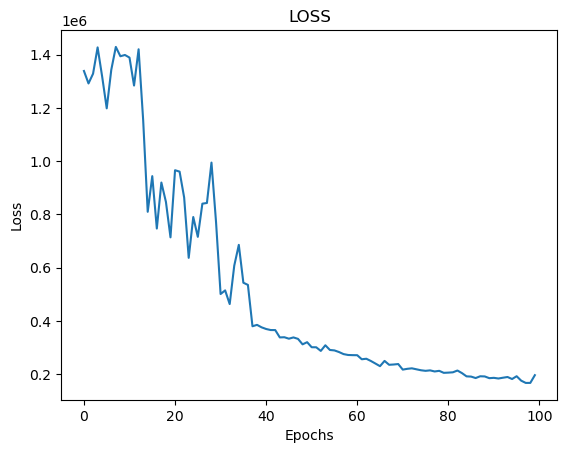

Root Mean Squared Error :  1855193.9579950431


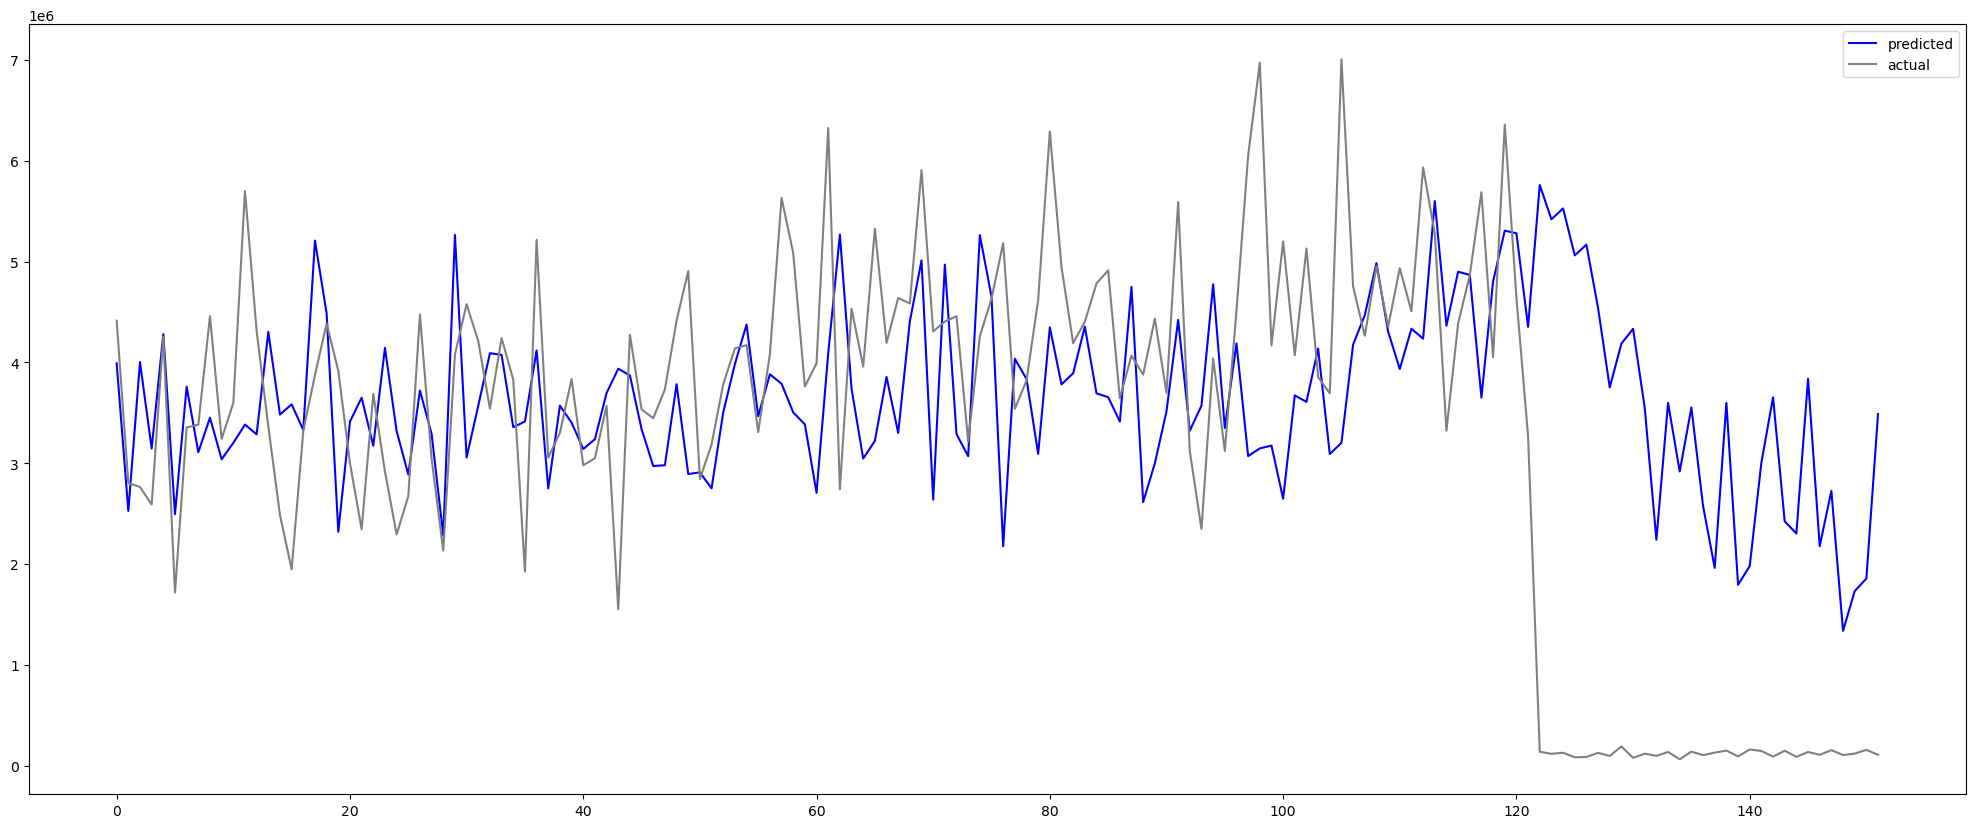

In [12]:
# hyper parameters
layer1_neurons = 128
layer2_neurons = 35
activation_func = 'relu'
epochs = 100
batch_sizes = 2

model_1 = Sequential()
model_1.add(LSTM(layer1_neurons, activation='relu', input_shape=(1, 365), return_sequences= True))
model_1.add(LSTM(layer2_neurons, activation='relu', input_shape=(1, 365), return_sequences= False))
model_1.add(Dense(1))

model_1.compile(loss='mae', optimizer='adam')

history = model_1.fit(X_train, y_train, batch_size=batch_sizes, epochs=epochs, verbose=1)


plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("LOSS")
plt.show()


y_pred = model_1.predict(X_test, verbose=0)

rmse = (mean_squared_error(y_test , y_pred))**0.5
print("Root Mean Squared Error : " , rmse )


plt.figure(figsize=(25,10))
plt.plot(y_pred , color = 'blue')
plt.plot(y_test , color = 'grey')
plt.legend(labels = ['predicted' , 'actual'])
plt.show()

# Prophet

In [13]:
# Rename the columns to 'ds' and 'y' for Prophet
train, test = train_test_split(time_series_data, test_size=0.2, shuffle= False)
prophet_train = train.rename(columns={'OrderDate': 'ds', 'SalesAmount': 'y'})
prophet_test = test.rename(columns={'OrderDate': 'ds', 'SalesAmount': 'y'})

In [14]:
prophet_test

,ds,y
899,2013-06-18,4828905.55
900,2013-06-19,4592306.55
901,2013-06-20,2369922.32
902,2013-06-21,3275778.65
903,2013-06-22,3253025.91
...,...,...
1119,2014-01-24,105375.93
1120,2014-01-25,119518.92
1121,2014-01-26,156699.38
1122,2014-01-27,107789.15


In [15]:
# Initialize Prophet model
model = Prophet()

# Fit the model on the training data
model.fit(prophet_train)

# Make predictions on the test data
pred = model.predict(prophet_test)

mse = mean_squared_error(prophet_test['y'], pred['yhat'])

# Calculate the root mean squared error
rmse = np.sqrt(mse)

print("Root Mean Squared Error (RMSE):", rmse)

13:09:28 - cmdstanpy - INFO - Chain [1] start processing
13:09:28 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Squared Error (RMSE): 2341139.456859869


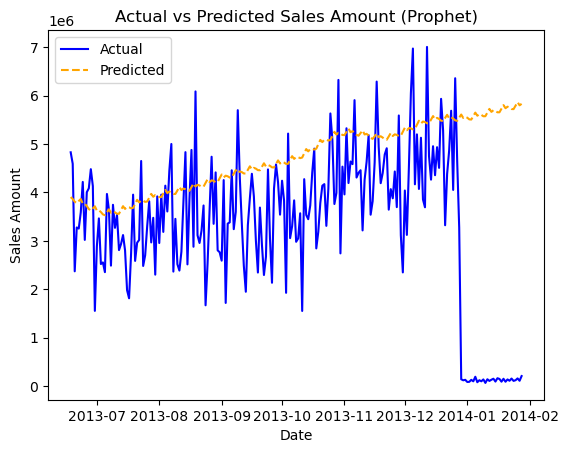

In [16]:
# Plot actual values
plt.plot(prophet_test['ds'], prophet_test['y'], label='Actual', color='blue')

# Plot predicted values
plt.plot(pred['ds'], pred['yhat'], label='Predicted', linestyle='--', color='orange')

plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.title('Actual vs Predicted Sales Amount (Prophet)')
plt.legend()
plt.show()

# ARIMA

In [17]:
train, test = train_test_split(time_series_data, test_size=0.2, shuffle= False)

In [18]:
# BEST MODEL
# Convert time series data to numpy arrays
train_values = train['SalesAmount'].values
test_values = test['SalesAmount'].values

# Fit ARIMA model on training data
model = ARIMA(train_values, order=(3,0,1))  # Example order, adjust as needed
model_fit = model.fit()

# Forecast on test data
forecast = model_fit.forecast(steps=len(test_values))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_values, forecast))
print("RMSE:", rmse)


RMSE: 1614159.8276116785


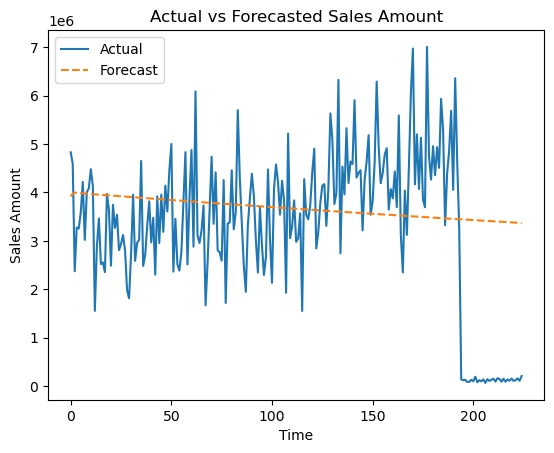

In [19]:
# Plot actual values
plt.plot(test_values, label='Actual')

# Plot forecasted values
plt.plot(forecast, label='Forecast', linestyle='--')

plt.xlabel('Time')
plt.ylabel('Sales Amount')
plt.title('Actual vs Forecasted Sales Amount')
plt.legend()
plt.show()